# 3DREAM: Three dimensional B1+ mapping

Demo code for the paper "Whole-brain B1-mapping using three dimensional DREAM" by Philipp Ehses, Daniel Brenner, Rüdiger Stirnberg, Eberhard Pracht, and Tony Stöcker.

Dependencies:
- python/ipython 2.x or 3.x
- argparse
- numpy
- matplotlib
- nibabel

In [18]:
# import of external libraries & general configuration

# python 2 & 3 compatible:
from __future__ import division, print_function

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib

mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

## Load data and show raw images

The dimensions in the nifti file are in the following order:

0. first phase encoding
1. read/frequency encoding
2. second phase encoding
3. repetitions (STE, FID)

This order is very important for the blurring compensation later. To simplify the rest of reconstruction process, we make sure that the two phase-encoding directions are in the first two dimensions of the numpy arrays <code>dream_r1</code> and <code>dream_r4</code>.

C:\Users\Kire\Anaconda3\envs\DatVis\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.
C:\Users\Kire\Anaconda3\envs\DatVis\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


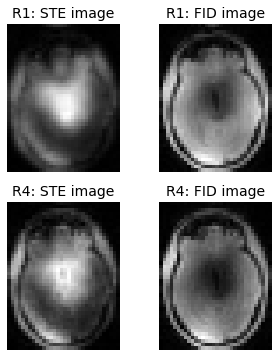

In [19]:
dream_r1 = nib.load('3DREAM_R1.nii.gz').get_data()
dream_r4 = nib.load('3DREAM_R4.nii.gz').get_data()

# make sure that phase-encoding directions are in first two dimensions:
dream_r1 = np.moveaxis(dream_r1, 2, 1)
dream_r4 = np.moveaxis(dream_r4, 2, 1)

zpos = 24

fig = plt.figure(figsize=(5,6));
# fig.suptitle("R = 1");

plt.subplot(221);
plt.title('R1: STE image');
plt.imshow(dream_r1[:,:,zpos,0], cmap='gray');
plt.axis('off');

plt.subplot(222);
plt.title('R1: FID image');
plt.imshow(dream_r1[:,:,zpos,1], cmap='gray');
plt.axis('off');


# fig = plt.figure();
# fig.suptitle("R = 4");

plt.subplot(223);
plt.title('R4: STE image');
plt.imshow(dream_r4[:,:,zpos,0], cmap='gray');
plt.axis('off');

plt.subplot(224);
plt.title('R4: FID image');
plt.imshow(dream_r4[:,:,zpos,1], cmap='gray');
plt.axis('off');

You should be able to appreciate how the higher acceleration factor helps to reduce blurring (especially in the STE image).

## Conventional DREAM flip angle map

The preparation flip angle alpha can be obtained from the two contrasts according to Nehrke et al. 2012:

$$
\alpha = \arctan{\sqrt{\frac{2 S_0^{STE}}{{S_0^{FID}}}}}
$$

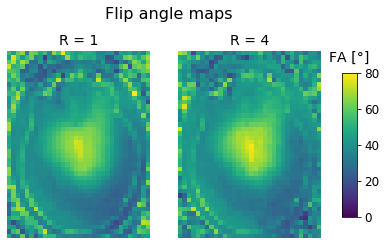

In [20]:
def calc_fa(ste, fid):
    famap = np.rad2deg(np.arctan(np.sqrt(2. * ste/fid)))
    return famap

fa_r1 = calc_fa(dream_r1[:,:,:,0], dream_r1[:,:,:,1])
fa_r4 = calc_fa(dream_r4[:,:,:,0], dream_r4[:,:,:,1])


fig, axes = plt.subplots(nrows=1, ncols=2);
fig.suptitle("Flip angle maps");

axes[0].set_title('R = 1');
axes[0].imshow(fa_r1[:,:,zpos], cmap='viridis', vmin=0, vmax=80);
axes[0].axis('off');

axes[1].set_title('R = 4');
im = axes[1].imshow(fa_r4[:,:,zpos], cmap='viridis', vmin=0, vmax=80);
axes[1].axis('off');

fig.subplots_adjust(right=0.85);
cbar_ax = fig.add_axes([0.9, 0.25, 0.035, 0.5]);
cbar_ax.set_title('FA [°]', pad=12);
fig.colorbar(im, cax=cbar_ax);

A bright ring around the brain is clearly visible in both maps, but it appears more pronounced in the unaccelerated data.

This ring is a result of the different blurring levels that are present in the STE and FID images (dividing differently blurred images by one another is not such a great idea).

## Blurring Compensation

In order to compensate for the stronger blurring in the STE image, we first need some information about sequence parameters and the phase-encoding order.

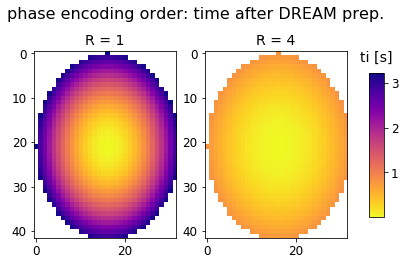

In [21]:
from DreamMap import approx_sampling, global_filter, local_filter
# %run DreamMap.py

# we need some information about the sequence:
tr = 3.06e-3
alpha = 60          # preparation FA
beta = 6            # readout FA
dummies = 1         # number of dummy scans before readout echo train starts
etl_r1 = 1049       # echo train length for R = 1
etl_r4 = 266        # echo train length for R = 4
etd_r1 = etl_r1*tr  # echo train duration for R = 1
etd_r4 = etl_r4*tr  # echo train duration for R = 4

# and a T1 estimate:
t1 = 2.   # [s] - approximately gray matter T1 @ 7T

# we also need to estimate the "inversion time" ti (analogue to IR experiments)
# i.e. the time after DREAM preparation after which each k-space line is acquired
# to do this, there's a helper function that approximates the spiral-out PE order:
ti_r1 = approx_sampling(dream_r1.shape[:2], etl_r1, tr, dummies)
ti_r4 = approx_sampling(dream_r4.shape[:2], etl_r4, tr, dummies)


fig, axes = plt.subplots(nrows=1, ncols=2);
fig.suptitle("phase encoding order: time after DREAM prep.");

axes[0].set_title('R = 1');
axes[0].imshow(ti_r1, cmap='plasma_r', vmin=np.nanmin(ti_r1), vmax=np.nanmax(ti_r1));
# axes[0].axis('off')

axes[1].set_title('R = 4');
im = axes[1].imshow(ti_r4, cmap='plasma_r', vmin=np.nanmin(ti_r1), vmax=np.nanmax(ti_r1));
# axes[1].axis('off')

fig.subplots_adjust(right=0.85);
cbar_ax = fig.add_axes([0.9, 0.25, 0.035, 0.5]);
cbar_ax.set_title('ti [s]', pad=12);
fig.colorbar(im, cax=cbar_ax);

## Global blurring compensation technique

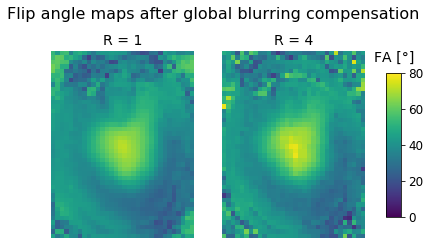

In [22]:
global_r1 = global_filter(dream_r1[:,:,:,0], dream_r1[:,:,:,1], ti_r1, alpha, beta, tr, t1)
global_r4 = global_filter(dream_r4[:,:,:,0], dream_r4[:,:,:,1], ti_r4, alpha, beta, tr, t1)

fig, axes = plt.subplots(nrows=1, ncols=2);
fig.suptitle("Flip angle maps after global blurring compensation");

axes[0].set_title('R = 1');
axes[0].imshow(global_r1[:,:,zpos], cmap='viridis', vmin=0, vmax=80);
axes[0].axis('off');

axes[1].set_title('R = 4');
im = axes[1].imshow(global_r4[:,:,zpos], cmap='viridis', vmin=0, vmax=80);
axes[1].axis('off');

fig.subplots_adjust(right=0.85);
cbar_ax = fig.add_axes([0.9, 0.25, 0.035, 0.5]);
cbar_ax.set_title('FA [°]', pad=12);
fig.colorbar(im, cax=cbar_ax);

The ring around the brain seems to be gone now.


## Local iterative blurring compensation technique
We use the global compensated maps as an initial guess (fmap=global_rX).

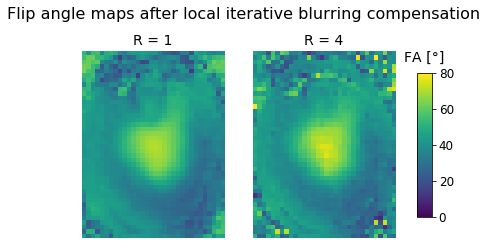

In [23]:
local_r1, _ = local_filter(dream_r1[:,:,:,0], dream_r1[:,:,:,1], ti_r1, alpha, beta, tr, t1, fmap=global_r1)
local_r4, _ = local_filter(dream_r4[:,:,:,0], dream_r4[:,:,:,1], ti_r4, alpha, beta, tr, t1, fmap=global_r4)


fig, axes = plt.subplots(nrows=1, ncols=2);
fig.suptitle("Flip angle maps after local iterative blurring compensation");

axes[0].set_title('R = 1');
axes[0].imshow(local_r1[:,:,zpos], cmap='viridis', vmin=0, vmax=80);
axes[0].axis('off');

axes[1].set_title('R = 4');
im = axes[1].imshow(local_r4[:,:,zpos], cmap='viridis', vmin=0, vmax=80);
axes[1].axis('off');

fig.subplots_adjust(right=0.85);
cbar_ax = fig.add_axes([0.9, 0.25, 0.035, 0.5]);
cbar_ax.set_title('FA [°]', pad=12);
fig.colorbar(im, cax=cbar_ax);

On first glance, this looks very similar to the global compensation technique. However, as our analysis in the paper shows, there is still a slight improvement that only costs us a small amount of computation time. Still, the global compensation technique is a viable option in case a simple and very fast compensation technique is required.

## Summary of the Results

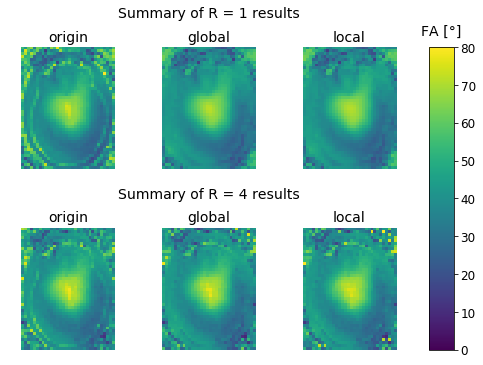

In [24]:
plt.figure(figsize=(8,6));
gs = mpl.gridspec.GridSpec(nrows = 5, ncols = 4, width_ratios=[1, 1, 1, 0.2], height_ratios=[0.1, 1., 0.1, 0.1, 1.]);

ax_t1 =  plt.subplot(gs[0,:-1]);
ax_t1.set_title("Summary of R = 1 results");
ax_t1.axis('off');

ax1 = plt.subplot(gs[1,0]);
ax1.set_title('origin');
ax1.imshow(fa_r1[:,:,zpos], cmap='viridis', vmin=0, vmax=80);
ax1.axis('off');

ax2 = plt.subplot(gs[1,1]);
ax2.set_title('global');
ax2.imshow(global_r1[:,:,zpos], cmap='viridis', vmin=0, vmax=80);
ax2.axis('off');

ax3 = plt.subplot(gs[1,2]);
ax3.set_title('local');
ax3.imshow(local_r1[:,:,zpos], cmap='viridis', vmin=0, vmax=80);
ax3.axis('off');

ax_t2 =  plt.subplot(gs[3,:-1]);
ax_t2.set_title("Summary of R = 4 results");
ax_t2.axis('off');

ax4 = plt.subplot(gs[4,0]);
ax4.set_title('origin');
ax4.imshow(fa_r4[:,:,zpos], cmap='viridis', vmin=0, vmax=80);
ax4.axis('off');

ax5 = plt.subplot(gs[4,1]);
ax5.set_title('global');
ax5.imshow(global_r4[:,:,zpos], cmap='viridis', vmin=0, vmax=80);
ax5.axis('off');

ax6 = plt.subplot(gs[4,2]);
ax6.set_title('local');
im = ax6.imshow(local_r4[:,:,zpos], cmap='viridis', vmin=0, vmax=80);
ax6.axis('off');


cbar_ax = plt.subplot(gs[1:,3]);
cbar_ax.set_title('FA [°]', pad=12);
fig.colorbar(im, cax=cbar_ax);

## Command line interface
DreamMap.py also has a command line interface that allows the direct calculation of flip angle maps from nifti files that include the two contrasts (STE & FID). The following system call will give us the uncorrected flip angle map, the global compensated, as well as the local iterative compensated map.

Here are the availaible arguments that can be passed to the script:

In [25]:
%run DreamMap.py

usage: DreamMap.py [-h] -i INFILE [-o OUTFILE] [-g GLOBAL_OUT] [-l LOCAL_OUT]
                   [--alpha ALPHA] [--beta BETA] [--tr TR] [--etl ETL]
                   [--dummies DUMMIES] [--t1 T1] [--niter NITER]
                   [--nbins NBINS] [--blur_read] [--read_dim READ_DIM]
DreamMap.py: error: the following arguments are required: -i/--infile/--in


SystemExit: 2

### Running the script
DreamMap.py requires the same information about the acquisition and sampling that we needed in this demo code, so we need to supply that via command line arguments. For some arguments there are reasonable default values set, so we don't need to supply them all.

The 'read_dim' argument is a very important one, as this determines which dimensions are assumed to be the phase-encoding dimensions (in which the blurring compensation is applied)!

In [26]:
%run DreamMap.py -i 3DREAM_R4.nii.gz --alpha 60 --beta 6 --tr 3.06e-3 --etl 266 --dummies 1 --t1 2 --read_dim 1 -o fa_r4_origin.nii.gz -g fa_r4_global.nii.gz -l fa_r4_local.nii.gz

C:\Users\Kire\Desktop\Kniga\3Dream_book\content\features\DreamMap.py:223: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = nii.get_data()


alpha =  60.0
beta =  6.0
etl =  266.0
tr =  0.00306
t1 =  2.0


We should now have three new nifti files. Let's check the map from the local compensation technique (should be pretty much identical to the map that we reconstructed before):

C:\Users\Kire\Anaconda3\envs\DatVis\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.


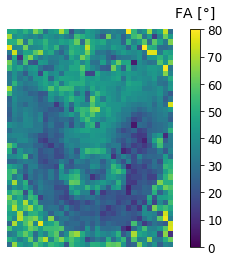

In [27]:
newmap = nib.load('fa_r4_local.nii.gz').get_data()
plt.imshow(newmap[:,12,:], vmin=0, vmax=80);
plt.axis('off');
cbar = plt.colorbar();
cbar.ax.set_title('FA [°]', pad=12);

In [28]:
np.shape(newmap)

(42, 42, 32)